# Recommender System - Content Based Filtering

Dataset: **MovieLens** *accessed from* https://files.grouplens.org/datasets/movielens/ml-latest-small.zip


<div style="padding:5px; background-color: #645CAA; text-align: center; font-size: 16pt; border-radius:10px;">Table of Contents</div>
<br/>

- [Importing Libraries](#importing-libraries)
- [Data Loading](#data-loading)
  - [Ekstrak Data](#ekstrak-data)
- [Data Exploration](#data-exploration)
  - [Deskripsi Variabel](#deskripsi-variabel)
  - [Menangani Missing Value](#menangani-missing-value)
  - [Menangani Outliers](#menangani-outliers)
  - [Univariate Analysis](#univariate-analysis)
    - [Fitur movieId](#fitur-movieid)
    - [Fitur title](#fitur-title)
    - [Fitur genres](#fitur-genres)
- [Data Preparation](#data-preparation)
  - [One Hot Encoding](#one-hot-encoding)
- [Model Development](#model-development)
  - [Jaccard Similarity (Ground Truth)](#jaccard-similarity-ground-truth)
  - [Cosine Similarity](#cosine-similarity)
  - [Euclidean Similarity](#euclidean-similarity)
- [Evaluasi Model](#evaluasi-model)
  - [Sampel Film untuk Evaluasi](#sampel-film-untuk-evaluasi)
  - [Top-k Rekomendasi](#top-k-rekomendasi)
    - [Dengan Jaccard Similarity (Ground Truth)](#dengan-jaccard-similarity-ground-truth)
    - [Dengan Cosine Similarity](#dengan-cosine-similarity)
    - [Dengan Euclidean Similarity](#dengan-euclidean-similarity)
  - [Skor Metrik (nDCG@k)](#skor-metrik-ndcgk)
  - [Komparasi Waktu Komputasi](#komparasi-waktu-komputasi)
- [Kesimpulan](#kesimpulan)
- [Daftar Referensi](#daftar-referensi)
- [Data Author](#data-author)

## Importing Libraries

In [ ]:
import time
import random
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numba import njit
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import pairwise_distances

## Data Loading

In [ ]:
!wget 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

--2022-11-13 05:04:52--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.59MB/s    in 0.2s    

2022-11-13 05:04:52 (4.59 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



### Ekstrak Data

In [ ]:
local_zip = 'ml-latest-small.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/')
zip_ref.close()

## Data Exploration

In [ ]:
df_movies = pd.read_csv('/ml-latest-small/movies.csv')
print("Shape:", df_movies.shape)
df_movies.head()

Shape: (9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


*Output* kode di atas memberikan informasi sebagai berikut:
* Ada 9742 baris (*records* atau jumlah pengamatan) dalam dataset.
* Terdapat 3 kolom (fitur) yaitu `movieId`, `title`, `genres`.

### Deskripsi Variabel

Berdasarkan informasi dari sumber dataset, variabel & attribute pada dataset *MovieLens Latest Datasets* (`movies.csv`) adalah sebagai berikut:
*  `movieId` (tipe: *numerical*) adalah identitas (Id) *movie* atau film yang berupa bilangan bulat yang berbeda dengan yang lainnya.
* `title` (tipe: *categorical*) adalah judul film yang diimpor dari https://www.themoviedb.org/.
* `genres` (tipe: *categorical*) adalah sebuah klasifikasi atau jenis dari film.

Setelah memahami deskripsi variabel pada data, langkah selanjutnya adalah mengecek informasi pada dataset dengan fungsi `info()` berikut:

In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Dari *output* di atas, terlihat bahwa:
* Kolom / fitur `movieId` merupakan fitur numerik sedangkan `title` dan `genres` merupakan fitur kategorikal.
* Tipe data pada fitur `movieId` sudah sesuai yaitu `int64` (Id berupa bilangan bulat).
* Pada fitur kategorikal (`title` & `genres`) secara default disimpan berupa tipe data `object`, mengingat tipe data `string` mempunyai batasan panjang karakter.
* Fitur `genres` merupakan fitur utama dalam menentukan kemiripan antar film pada sistem rekomendasi yang akan dibuat.

### Menangani Missing Value

Untuk mendeteksi *missing value* digunakan fungsi `isnull().sum()` dan diperoleh sebagai berikut.

In [ ]:
df_movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

Dari *output* di atas, terlihat bahwa setiap fitur tidak memiliki nilai *Null* sehingga sekarang kita bisa lanjutkan ke tahap selanjutnya yaitu menangani *outliers*.

### Menangani Outliers

Secara intuitif salah satu ciri titik *outlier* yang `ideal` dalam data kategorikal adalah nilainya sangat jarang muncul. Kelangkaan nilai tersebut dapat diukur dengan menghitung frekuensi kemunculan setiap data kategorikal dalam dataset [[1] (Hal 3299)](https://www.eecs.ucf.edu/georgiopoulos/sites/default/files/247.pdf). Selanjutnya kita akan mengecek frekuensi kemunculan setiap genre (data kategorikal):

In [ ]:
# Unique genre film
dict_num_unique_genre = {}

# Callback untuk menghitung jumlah genre yang unique
def genre_handler(str_genre):
  list_genre = str_genre.split('|')
  for genre in list_genre:
    if genre in dict_num_unique_genre:
      dict_num_unique_genre[genre] += 1
    else:
      dict_num_unique_genre[genre] = 1

df_movies['genres'].apply(genre_handler)

# Konversi data dari dictionary ke dalam dataframe
df_num_genres = pd.DataFrame.from_dict(
    dict_num_unique_genre,
    orient='index',
    columns=['Jumlah Film'])

df_num_genres['Jumlah Film'].sort_values(ascending=False).tail(5)

Musical               334
Western               167
IMAX                  158
Film-Noir              87
(no genres listed)     34
Name: Jumlah Film, dtype: int64

Dari *output* di atas, kita peroleh informasi bahwa genre `(non genres listed)` adalah yang paling jarang muncul. Dengan total 34 judul film dengan genre `(no genres listed)`.

Jika mengacu pada definisi outlier `ideal` (pernyataan sebelumnya) maka data 34 film dengan genre `(no genres listed)` dapat kita nyatakan sebagai *outlier*. Namun *outlier* tersebut tidak akan kita hapus karena sistem rekomendasi yang akan kita buat akan mendukung genre `(non genres listed)`. Jika dihapus maka 34 film tersebut menjadi kurang mendapatkan sorotan, karena tidak akan pernah muncul dalam daftar rekomendasi. Tentunya hal ini akan menurunkan nilai jual produk film.

### Univariate Analysis

#### Fitur movieId

Pada fitur `movieId` seharusnya tiap film memiliki identitas yang berbeda dengan yang lainnya, oleh karena itu pada tahap ini akan dicek duplikasi data pada `movieId`.

In [ ]:
# Unique movieId vs Total Data
pd.DataFrame({"Unique movieId": df_movies['movieId'].nunique(),
              "Total Data": len(df_movies['movieId'])}, index=["Jumlah Film"])

,Unique movieId,Total Data
Jumlah Film,9742,9742


Dari *output* di atas, didapat bahwa jumlah `movieId` yang berbeda (*unique*) sama dengan total data. Hal ini menunjukkan bahwa pada fitur `movieId` tiap film memiliki identitas (Id) yang berbeda-beda.

#### Fitur title

Judul pada film seharusnya berbeda (tidak identik) namun berdasarkan informasi dari [sumber dataset (grouplens.org)](https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html#:~:text=Errors%20and%20inconsistencies) dimungkinkan terjadi kesalahan dan inkonsistensi pada judul film.

In [ ]:
# Unique title vs Total Data
pd.DataFrame({"Unique title": df_movies['title'].nunique(),
              "Total Data": len(df_movies['title'])}, index=["Jumlah Film"])

,Unique title,Total Data
Jumlah Film,9737,9742


Dari *output* di atas, jumlah `title` yang berbeda (*unique*) tidak sama dengan total data dengan selisih 9742 - 9737 = 5 *data point*. Untuk menindaklanjuti temuan tersebut, kita perlu mengecek data dengan `title` yang duplikat.

In [ ]:
# Cek title yang duplikat
df_row_duplicate = df_movies[df_movies.duplicated(['title'], keep=False)]
display(df_row_duplicate)

,movieId,title,genres
650,838,Emma (1996),Comedy|Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
5601,26958,Emma (1996),Romance
5854,32600,Eros (2004),Drama
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


Dari hasil pengecekan diperoleh bahwa terdapat data yang duplikat. Kita akan menanganinya dengan menghapus data `title` yang duplikat dan menyisakan `title` dengan `genres` yang lebih banyak (variatif). Karena dengan menyisakan film dengan genre yang lebih beragam akan meningkatkan relevansi dengan lebih banyak film lain sesuai dengan kemiripan genrenya.

In [ ]:
list_remove_index = []

list_title_duplicate = df_row_duplicate['title'].unique()
for title in list_title_duplicate:
  num_max_genre = 0
  idx_keep = None
  list_idx = df_row_duplicate.index[df_row_duplicate['title'] == title].tolist()
  for idx in list_idx:
    num_genre = len(df_row_duplicate['genres']._get_value(idx).split('|'))
    if idx_keep == None:
      idx_keep = idx
    # Menyisakan film dengan genre yang lebih beragam
    if num_genre > num_max_genre:
      num_max_genre = num_genre
      idx_keep = idx
  list_idx.remove(idx_keep)
  list_remove_index.append(list_idx[0])

print("Daftar index data film yang duplikat dan akan dihapus", list_remove_index)

Daftar index data film yang duplikat dan akan dihapus [5601, 9468, 4169, 5854, 6932]


Selanjutnya kita akan menghapus data film yang duplikat menggunakan fungsi `drop()` dengan index `list_remove_index` yang berisi [5601, 9468, 4169, 5854, 6932].

In [ ]:
# Menghapus film yang duplikat berdasarkan daftar index yang telah dibuat sebelumnya
df_movies.drop(list_remove_index, inplace=True)

# Mengecek kembali banyak unique title vs total data
pd.DataFrame({"Unique title": df_movies['title'].nunique(),
              "Total Data": len(df_movies['title'])}, index=["Jumlah Film"])

,Unique title,Total Data
Jumlah Film,9737,9737


Setelah dilakukan penghapusan data yang duplikat, berdasarkan hasil *output* diatas, sekarang jumlah `title` yang berbeda (*unique*) sama dengan total data.

#### Fitur genres

Sebelumnya pada tahap menangani *outlier*, kita telah melihat daftar lima genre dengan frekuensi kemunculan terendah. Pada tahap ini kita akan mengeksplor distribusi frekuensi kemunculan setiap genre. Untuk mempermudah dalam menganalisa, kita gunakan fungsi `barplot()` sebagai berikut.

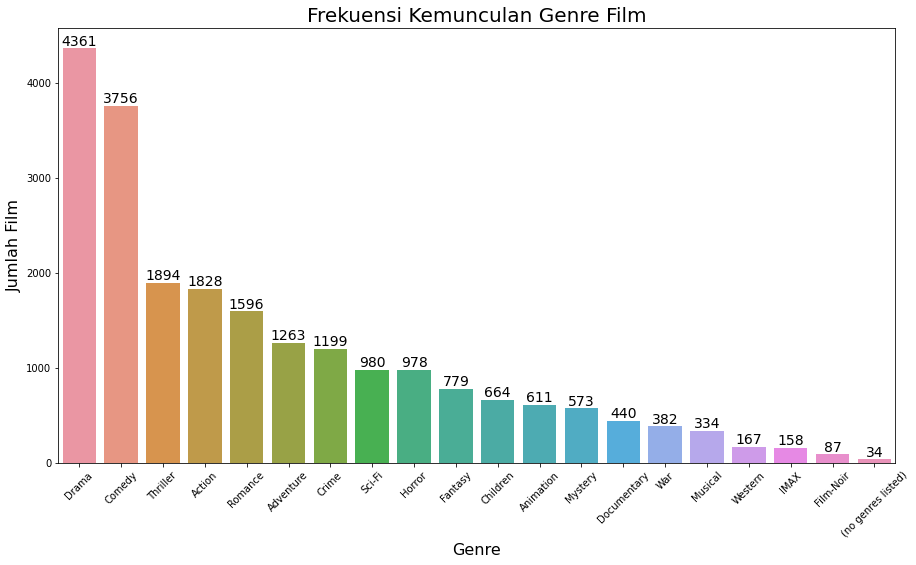

In [ ]:
# Visualisasi dengan barplot
x = df_num_genres['Jumlah Film'].sort_values(ascending=False)
plt.figure(figsize=(15, 8))
sns.barplot(x=x.index, y=x)
plt.title("Frekuensi Kemunculan Genre Film", fontsize=20)
plt.gca().set_ylabel('Jumlah Film', fontsize=16)
plt.gca().set_xlabel('Genre', fontsize=16)
plt.xticks(rotation=45)

# Alternatif pakai bar_label (untuk matplotlib versi 3.4 ke atas)
xlocs, _ = plt.xticks()
for i, v in enumerate(x):
    plt.text(xlocs[i], v, str(v), fontsize=14,
             horizontalalignment="center",
             verticalalignment="bottom")

plt.show()

Dari hasil visualisasi di atas, genre yang sering muncul pada film adalah `Drama` diikuti `Comedy` dan `Thriller`. Sedangkan genre yang jarang muncul pada film adalah `(non genres listed)` dan cukup jelas bahwa pada dataset MovieLens ada 20 jenis genre sebagai berikut:
* Action
* Adventure
* Animation
* Children's
* Comedy
* Crime
* Documentary
* Drama
* Fantasy
* Film-Noir
* Horror
* IMAX
* Musical
* Mystery
* Romance
* Sci-Fi
* Thriller
* War
* Western
* (no genres listed)

Hal ini sedikit berbeda dengan jenis genre yang tertera pada [sumber dataset (grouplens.org)](https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html#:~:text=Errors%20and%20inconsistencies) yang tidak menuliskan genre `IMAX` (jenis film dengan *high-resolution cameras*).

Kemudian kita akan mengeksplor distribusi banyak genre setiap film dengan `barplot()` sebagai berikut.

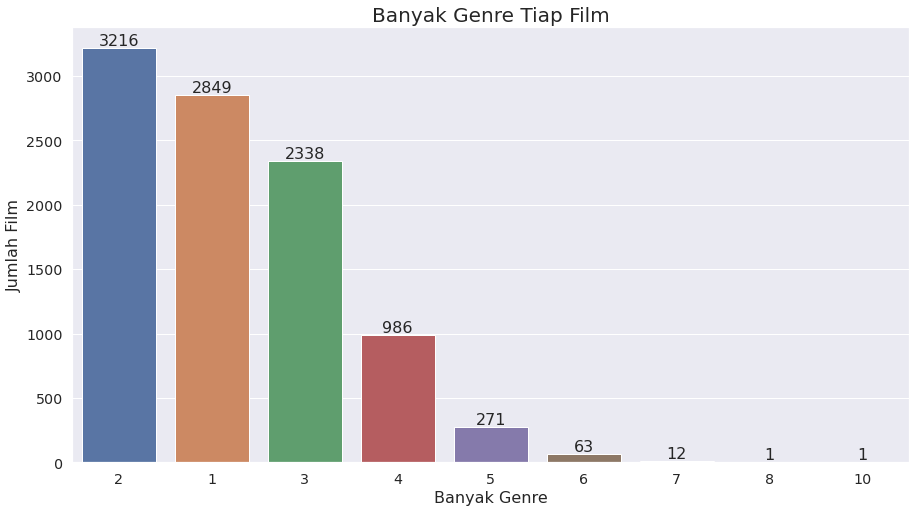

In [ ]:
# Banyak genre tiap film
dict_num_genre = {}

def genre_handler(str_genre):
  num_genre = str(len(str_genre.split('|')))
  if num_genre in dict_num_genre:
    dict_num_genre[num_genre] += 1
  else:
    dict_num_genre[num_genre] = 1

df_movies['genres'].apply(genre_handler)
df_num_genres = pd.DataFrame.from_dict(
    dict_num_genre,
    orient='index',
    columns=['Jumlah Film'])

# Visualisasi dengan barplot
x = df_num_genres['Jumlah Film'].sort_values(ascending=False)
plt.figure(figsize=(15, 8))
sns.set(font_scale = 1.3)
sns.barplot(x=x.index, y=x)
plt.title("Banyak Genre Tiap Film", fontsize=20)
plt.gca().set_ylabel('Jumlah Film', fontsize=16)
plt.gca().set_xlabel('Banyak Genre', fontsize=16)

# Alternatif pakai bar_label (untuk matplotlib versi 3.4 ke atas)
xlocs, _ = plt.xticks()
for i, v in enumerate(x):
    plt.text(xlocs[i], v, str(v), fontsize=16,
             horizontalalignment="center",
             verticalalignment="bottom")

plt.show()

Dari hasil visualisasi di atas, mayoritas film memiliki 1 hingga 3 genre yang berbeda. Sedangkan untuk banyak genre maksimal pada satu film di dataset adalah 10 genre yang berbeda. 

## Data Preparation

Pada tahap ini, kita akan mempersiapkan data ke dalam bentuk matrix korelasi antara judul film dengan genre. Nilai setiap elemen pada matrik tersebut berupa angka 1 (ada) atau 0 (tidak ada). Contoh pada film A mempunyai genre Drama dan tidak memiliki genre Komedi maka untuk elemen (A, Drama) bernilai 1 sedangkan elemen (A, Komedi) bernilai 0.

Dengan kata lain kita akan melakukan metode *`One-Hot Encoding`*` (OHE)` dari fitur kategorikal (genre) menjadi numerik. Metode ini dipilih karena pada fitur genre sudah memiliki batasan nilai (20 genre yang sudah ditentukan) dan setiap genrenya memiliki bobot yang sama walaupun berbeda frekuensi kemunculannya. Kesamaan bobot setiap genre dapat diwakilkan dengan data boolean (1 atau 0).

Hal itulah yang membuat metode seperti `Count Vectorizer` dan `TF-IDF Vectorizer` kurang sesuai untuk kasus ini.

### One Hot Encoding

In [ ]:
df_ohe_movies = df_movies['genres'].str.get_dummies(sep='|').set_index(df_movies['title'])
pd.set_option("display.max_columns", 10)
df_ohe_movies.head(5)

,(no genres listed),Action,Adventure,Animation,Children,...,Romance,Sci-Fi,Thriller,War,Western
title,,,,,,,,,,,
Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0
Jumanji (1995),0,0,1,0,1,...,0,0,0,0,0
Grumpier Old Men (1995),0,0,0,0,0,...,1,0,0,0,0
Waiting to Exhale (1995),0,0,0,0,0,...,1,0,0,0,0
Father of the Bride Part II (1995),0,0,0,0,0,...,0,0,0,0,0


Dari hasil *output* di atas menunjukkan film Toy Story (1995) memiliki genre (*Adventure, Animation, Children*). Hal ini terlihat dari nilai elemen matriks 1 pada genre *Adventure, Animation, Children*. Selanjutnya, film Jumanji (1995) memiliki genre (*Adventure, Children*). Demikian seterusnya.

## Model Development

Pada tahap ini, untuk sistem rekomendasi yang dibuat akan menggunakan model dengan metode *Cosine Similarity* dan *Euclidean Similarity*. Sedangkan metode *Jaccard Similarity* dipilih sebagai metode untuk menentukan *ground truth* yang nantinya digunakan pada proses evaluasi.

### Jaccard Similarity (Ground Truth)


Jaccard Similarity untuk Kasus *Binary* [[2](Hal 4-5)](https://link.springer.com/article/10.1007/s13278-020-00660-9):
$$\text{S}_{\text{Jaccard}}(\vec{x}, \vec{y})=\frac{\text{N}_{11}}{\text{N}_{10}+\text{N}_{01}+\text{N}_{11}}$$
  Dengan:
  * $\text{N}_{11}$ adalah banyaknya elemen dengan index bersesuaian yang bernilai $1$ pada $x$ dan $y$.
  * $\text{N}_{10}$ adalah banyaknya elemen dengan index bersesuaian yang bernilai $1$ pada $x$ dan bernilai $0$ pada $y$.
  * $\text{N}_{01}$ adalah banyaknya elemen dengan index bersesuaian yang bernilai $0$ pada $x$ dan bernilai $1$ pada $y$.

Kelebihan utama metode Jaccard Similarity adalah menggunakan sudut pandang vektor sebagai himpunan yang cocok digunakan untuk sistem rekomendasi film (*content based filtering* - *by genre*). Metode ini dapat menangani dua film dengan banyak genre yang berbeda. Tingkat kemiripan dua film pada metode ini dipengaruhi oleh banyaknya elemen / genre yang sama (relevan). Semakin banyak genre yang relevan maka tingkat kemiripan akan meningkat. 

Namun tidak hanya itu, banyak genre lain yang berbeda (tidak relevan) juga mempunyai pengaruh untuk menurunkan kemiripan antara dua film tersebut. Sehingga tercipta keseimbangan tingkat kemiripan yang "ideal" antara dua film. Hal tersebutlah yang menjadikan metode ini dipilih sebagai *ground truth* pada kasus ini.

Sedangkan kekurangan dari metode ini adalah lamanya waktu komputasi untuk menangani data yang besar. Mengingat metode ini melakukan komputasi pada setiap elemen di vektor atau himpunan data.

Untuk implementasinya dengan membuat fungsi baru `jaccard_handler` mengisi nilai parameter `metric` pada fungsi `pairwise_distance` di *library* sklearn. Kemudian digunakan JIT Compiler dari *library* numba untuk optimalisasi kecepatan eksekusi kode.

In [ ]:
# Optimasi fungsi
@njit
def jaccard_handler(set_a, set_b):
  num_a_plus_b = 0
  num_intersect = 0
  for i, x in enumerate(set_a):
    if x != set_b[i]:
      num_a_plus_b += 1
    if x == 1 and set_b[i] == 1:
      num_intersect += 1
  return num_intersect / (num_intersect + num_a_plus_b)

In [ ]:
def jaccard_sim_handler(df_ohe, series_title):
  # Jauh lebih cepat dibanding metric=jaccard_score dari sklearn [tested]
  jaccard_sim = pairwise_distances(df_ohe_movies, metric=jaccard_handler)

  # Membuat dataframe dari variabel jaccard_sim dengan baris dan kolom berupa judul film
  df_jaccard_sim = pd.DataFrame(jaccard_sim, index=series_title, columns=series_title)

  # Melihat similarity matrix pada setiap film
  return df_jaccard_sim

In [ ]:
start = time.time()
df_jaccard_sim = jaccard_sim_handler(df_ohe_movies, df_movies['title'])
jaccard_exec_time = time.time() - start
print("Exec Time Jaccard Similarity (Seconds) :", jaccard_exec_time)

Exec Time Jaccard Similarity (Seconds) : 101.19560837745667


Dari hasil *output* di atas terlihat bahwa waktu komputasi masih lebih dari 1 menit (dengan Google Colab w/o GPU) untuk sekitar $9737 \times 9737 \approx 94 \times 10^6$ *entry data* saat ini. Hal tersebut tentu tentu kurang sesuai jika data terus mengalami pertumbuhan. Oleh karena itu, perlu dicari metode lain yang lebih baik. Namun sebelumnya akan dilakukan pengecekan terlebih dahulu hasil dari metode *Jaccard Similarity* sebagai berikut:

In [ ]:
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 10)
df_jaccard_sim

title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),...,Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
title,,,,,,,,,,,
Toy Story (1995),1.000000,0.600000,0.166667,0.142857,0.200000,...,0.500000,0.600000,0.000000,0.166667,0.200000
Jumanji (1995),0.600000,1.000000,0.000000,0.000000,0.000000,...,0.166667,0.200000,0.000000,0.000000,0.000000
Grumpier Old Men (1995),0.166667,0.000000,1.000000,0.666667,0.500000,...,0.200000,0.250000,0.000000,0.000000,0.500000
Waiting to Exhale (1995),0.142857,0.000000,0.666667,1.000000,0.333333,...,0.166667,0.200000,0.333333,0.000000,0.333333
Father of the Bride Part II (1995),0.200000,0.000000,0.500000,0.333333,1.000000,...,0.250000,0.333333,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
Black Butler: Book of the Atlantic (2017),0.500000,0.166667,0.200000,0.166667,0.250000,...,1.000000,0.750000,0.000000,0.500000,0.250000
No Game No Life: Zero (2017),0.600000,0.200000,0.250000,0.200000,0.333333,...,0.750000,1.000000,0.000000,0.250000,0.333333
Flint (2017),0.000000,0.000000,0.000000,0.333333,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000


Dari matrik *Jaccard Similarity* di atas, didapat bahwa matrik tersebut berukuran 9737 x 9737 dengan setiap elemennya mempunyai nilai antara 0 sampai 1. Jika nilai elemennya semakin mendekati nilai 1 maka tingkat kemiripannya semakin tinggi. Contoh film Jumanji (1995) dan No Game No Life: Zero (2017) teridentifikasi mirip dengan film Toy Story (1995) dengan skor kemiripan / relevansi sebesar 0.6. Contoh lain No Game No Life: Zero (2017) mirip dengan Black Butler: Book of the Atlantic (2017) dengan skor kemiripan 0.75.

### Cosine Similarity

Rumus Cosine Similarity didefinisikan sebagai berikut [[3]](http://www.snet.tu-berlin.de/fileadmin/fg220/courses/SS11/snet-project/recommender-systems_asanov.pdf):
$$\text{S}_{\text{Cosinus}}(\vec{x},\vec{y})=\cos(\theta)=\frac{\vec{x}\cdot\vec{y}}{\|\vec{x}\|\|\vec{y}\|}$$
Dengan:
* $\theta$ merupakan sudut antara vektor $\vec{x}$ dan $\vec{y}$.
* $\|\vec{x}\|$ dan $\|\vec{y}\|$ berturut-turut adalah besar atau panjang vektor $\vec{x}$ dan $\vec{y}$. Dengan rumus $\|\vec{x}\|=\sqrt{\sum_{i=1}^n{x_{i}^2}}$ dimana $x_{i}$ merupakan elemen vektor $\vec{x}$ posisi ke-$i$.

Kelebihan metode ini adalah tidak bergantung pada besarnya vektor. Contoh vektor $\vec{x}=[2, 0, 4]$ dengan vektor $\vec{y}=[1, 0, 2]$ yang memiliki arah yang sama namun berbeda besarannya (akibat berbeda nilai pada fiturnya). Jika vektor $\vec{x}$ dan $\vec{y}$ dihitung tingkat kemiripan atau relevansi dengan metode ini maka nilainya $1$ (kemiripan penuh). Namun kelebihan ini dapat menjadi kekurangan jika pada kasus tertentu, makna frekuensi kemunculan fitur menjadi penting. Sedangkan pada kasus ini, *Cosine Similarity* aman digunakan karena frekuensi tiap genre pada film mempunyai bobot yang sama yaitu 0 (tidak ada) atau 1 (ada).

Untuk implementasinya menggunakan fungsi `cosine_similarity()` dari *library* sklearn.

In [ ]:
def cosine_sim_handler(df_ohe, series_title):
  # Menghitung cosine similarity pada dataframe one-hot-encoding
  cosine_sim = cosine_similarity(df_ohe)

  # Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa judul film
  df_cosine_sim = pd.DataFrame(cosine_sim, index=series_title, columns=series_title)

  # Melihat similarity matrix pada setiap film
  return df_cosine_sim

In [ ]:
start = time.time()
df_cosine_sim = cosine_sim_handler(df_ohe_movies, df_movies['title'])
cosine_exec_time = time.time() - start
print("Exec Time Cosine Similarity (Seconds) :", cosine_exec_time)

Exec Time Cosine Similarity (Seconds) : 0.7583773136138916


In [ ]:
df_cosine_sim

title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),...,Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
title,,,,,,,,,,,
Toy Story (1995),1.000000,0.774597,0.316228,0.258199,0.447214,...,0.670820,0.774597,0.00000,0.316228,0.447214
Jumanji (1995),0.774597,1.000000,0.000000,0.000000,0.000000,...,0.288675,0.333333,0.00000,0.000000,0.000000
Grumpier Old Men (1995),0.316228,0.000000,1.000000,0.816497,0.707107,...,0.353553,0.408248,0.00000,0.000000,0.707107
Waiting to Exhale (1995),0.258199,0.000000,0.816497,1.000000,0.577350,...,0.288675,0.333333,0.57735,0.000000,0.577350
Father of the Bride Part II (1995),0.447214,0.000000,0.707107,0.577350,1.000000,...,0.500000,0.577350,0.00000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
Black Butler: Book of the Atlantic (2017),0.670820,0.288675,0.353553,0.288675,0.500000,...,1.000000,0.866025,0.00000,0.707107,0.500000
No Game No Life: Zero (2017),0.774597,0.333333,0.408248,0.333333,0.577350,...,0.866025,1.000000,0.00000,0.408248,0.577350
Flint (2017),0.000000,0.000000,0.000000,0.577350,0.000000,...,0.000000,0.000000,1.00000,0.000000,0.000000


Dengan *cosine similarity*, kita berhasil mengidentifikasi kemiripan antara satu film dengan film lainnya. Matriks tersebut berukuran 9737 film x 9737 film (masing-masing dalam sumbu X dan Y).

Dari hasil *output* di atas, setiap elemen mempunyai *range* 0 sampai 1, semakin mendekati 1 artinya kemiripannya semakin tinggi dan berlaku sebaliknya. *Range* pada nilai fungsi cosinus sebenarnya dari -1 sampai 1, namun karena elemen-elemen pada dataframe `df_ohe_movies` bernilai lebih dari sama dengan nol. Akibatnya nilai cosinusnya dari 0 sampai 1.

Sebagai contoh, film Waiting to Exhale (1995) dan Father of the Bride Part II (1995) teridentifikasi cukup mirip dengan film Grumpier Old Men (1995) dengan skor kemiripan lebih dari 0.7. Contoh lain, film Father of the Bride Part II (1995) teridentifikasi mirip dengan film Andrew Dice Clay: Dice Rules (1991) dengan skor kemiripan penuh (1).

### Euclidean Similarity

*Euclidean Distances* didefinisikan sebagai berikut:
$$\text{D}_{\text{Euclidean}}(\vec{x},\vec{y})=\sqrt{\sum^{n}_{i=1}(x_{i}-y_{i})^2}$$
Dengan $x_{i}$ dan $y_{i}$ berturut-turut adalah elemen ke-$i$ pada vektor $\vec{x}$ dan $\vec{y}$. 

Dalam buku berjudul `Programming Collective Intelligence [Page 10]` karya Toby Segaran (2007) [[4]](https://www.oreilly.com/library/view/programming-collective-intelligence/9780596529321/) mendefinisikan persamaan *Euclidean Similarity* sebagai berikut:
$$\text{S}_{\text{Euclidean}}(\vec{x},\vec{y})=\frac{1}{1+\text{D}_{\text{Euclidean}}(\vec{x}, \vec{y})}$$

Kelebihan Euclidean adalah dapat memperoleh nilai perbedaan antara dua vektor yang sama arahnya namun beda besarnya. Contoh vektor $\vec{x}=[2, 0, 4]$ dengan vektor $\vec{y}=[1, 0, 2]$ jika menggunakan algoritma *Cosine Similarity* maka didapat kedua vektor tersebut memiliki kesamaan penuh ($1$). Namun, jika menggunakan metode ini maka didapat perbedaan jarak sebesar:
$$\begin{align*}\text{D}_{\text{Euclidean}}(\vec{x},\vec{y})&=\sqrt{\sum^{n}_{i=1}(x_{i}-y_{i})^2}\\&=\sqrt{\sum^{3}_{i=1}(x_{i}-y_{i})^2}\\&=\sqrt{(2-1)^2 + (0-0)^2 + (4-2)^2}\\&=\sqrt{5}\approx2.236\end{align*}$$

Kemudian tingkat kemiripannya sebesar:

$$\begin{align*}\text{S}_{\text{Euclidean}}(\vec{x},\vec{y})&=\frac{1}{1+\text{D}_{\text{Euclidean}}(\vec{x}, \vec{y})}\\&=\frac{1}{1+2.236}\\&=0.309\end{align*}$$

Sedangkan kekurangan algoritma ini adalah fitur dengan frekuensi kemunculan paling banyak akan mendominasi fitur lain dalam hasil komputasi jarak euclideannya. Contoh vektor $\vec{u}=[10,2]$ dan $\vec{v}=[1, 1]$ dengan hasil jarak euclideannya didominasi oleh elemen $\vec{u}_{1}=10$ dan $\vec{v}_{1}=1$. Hal tersebut dapat diatasi dengan melakukan normalisasi atau standariasi pada data numerik [[3]](https://dl.acm.org/doi/pdf/10.1145/331499.331504). Pada kasus ini telah dilakukan normalisasi dengan *One-Hot Encoding* pada data kategorikal (genre) untuk menyamakan bobot setiap genre (frekuensi = ada tidaknya genre).

Untuk implementasinya, kita akan menggunakan fungsi `euclidean_distances()` dari *library* sklearn.

In [ ]:
def euclidean_sim_handler(df_ohe, series_title):
  # Menghitung euclidean distance pada dataframe one-hot-encoding
  euclidean_dist = euclidean_distances(df_ohe) # Shape: 9737 x 9737

  # Menghitung euclidean similarity
  # Metode cepat untuk handle 94 x 10^6 entries
  # Ref: https://stackoverflow.com/a/35216364
  f = lambda x: 1 / (1 + x)
  euclidean_sim = f(euclidean_dist)

  # Membuat dataframe dari variabel euclidean_sim dengan baris dan kolom berupa judul film
  df_euclidean_sim = pd.DataFrame(euclidean_sim, index=series_title, columns=series_title)

  # Melihat similarity matrix pada setiap film
  return df_euclidean_sim

In [ ]:
start = time.time()
df_euclidean_sim = euclidean_sim_handler(df_ohe_movies, df_movies['title'])
euclidean_exec_time = time.time() - start
print("Exec Time Euclidean Similarity (Seconds) :", euclidean_exec_time)

Exec Time Euclidean Similarity (Seconds) : 1.784877061843872


Dengan hasil matrik *Euclidean Similarity* nya sebagai berikut.

In [ ]:
df_euclidean_sim

title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),...,Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
title,,,,,,,,,,,
Toy Story (1995),1.000000,0.414214,0.309017,0.289898,0.333333,...,0.366025,0.414214,0.289898,0.309017,0.333333
Jumanji (1995),0.414214,1.000000,0.309017,0.289898,0.333333,...,0.309017,0.333333,0.333333,0.309017,0.333333
Grumpier Old Men (1995),0.309017,0.309017,1.000000,0.500000,0.500000,...,0.333333,0.366025,0.366025,0.333333,0.500000
Waiting to Exhale (1995),0.289898,0.289898,0.500000,1.000000,0.414214,...,0.309017,0.333333,0.414214,0.309017,0.414214
Father of the Bride Part II (1995),0.333333,0.333333,0.500000,0.414214,1.000000,...,0.366025,0.414214,0.414214,0.366025,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
Black Butler: Book of the Atlantic (2017),0.366025,0.309017,0.333333,0.309017,0.366025,...,1.000000,0.500000,0.309017,0.414214,0.366025
No Game No Life: Zero (2017),0.414214,0.333333,0.366025,0.333333,0.414214,...,0.500000,1.000000,0.333333,0.366025,0.414214
Flint (2017),0.289898,0.333333,0.366025,0.414214,0.414214,...,0.309017,0.333333,1.000000,0.366025,0.414214


Hasil *Euclidean Distance* ditransformasikan ke dalam skala 0 sampai 1 dengan persamaan *Euclidean Similarity*. Jika nilai elemen matriks mendekati 1 artinya kemiripannya semakin tinggi.

Sebagai contoh, film Father of the Bride Part II (1995) teridentifikasi mirip dengan film Andrew Dice Clay: Dice Rules (1991) dengan skor kemiripan penuh yaitu (1).

Kemudian jika kita cek persebaran nilai pada matriks tersebut, kita peroleh:

In [ ]:
np.unique(df_euclidean_sim)

array([0.2       , 0.2052131 , 0.21089672, 0.21712927, 0.22400924,
       0.23166248, 0.24025307, 0.25      , 0.26120387, 0.27429189,
       0.28989795, 0.30901699, 0.33333333, 0.3660254 , 0.41421356,
       0.5       , 1.        ])

Dari hasil *output* di atas, menunjukkan bahwa skor kemiripan tertinggi kedua adalah 0.5. Hal ini dikarenakan ada tepat satu genre yang berbeda pada dua film yang diperbandingkan. Sehingga nilai *Euclidean Distance* nya sama dengan $1$ dan *Euclidean Similarity* nya sama dengan $\frac{1}{1+1}=0.5$.

In [ ]:
# Cek perbedaan genre
df_movies[
    (df_movies['title'] == 'Grumpier Old Men (1995)') |
    (df_movies['title'] == 'Waiting to Exhale (1995)') |
    (df_movies['title'] == 'Father of the Bride Part II (1995)')]

,movieId,title,genres
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Contohnya film Waiting to Exhale (1995) dan Father of the Bride Part II (1995) teridentifikasi cukup mirip (berbeda satu genre) dengan film Grumpier Old Men (1995) dengan skor kemiripan sama dengan 0.5 (dapat dilihat pada tabel di atas).

## Evaluasi Model

Setelah mendapatkan matrik korelasi antar film dengan metode *Cosine Similarity* dan *Euclidean Similarity* selanjutnya adalah membangun sistem rekomendasi berdasarkan matrik korelasi yang telah dibuat. Namun, sebelum itu perlu ditentukan terlebih dahulu sampel yang akan digunakan untuk mengevaluasi performa setiap metode.

### Sampel Film untuk Evaluasi

Untuk pemilihan sampelnya akan dipilih secara acak untuk setiap banyak genre yang berbeda pada dataset. Dari bagian sebelumnya (Visualisasi Banyak Genre Tiap Film), diketahui bahwa minimal banyak genre adalah 1 dan maksimalnya adalah 10. Sehingga untuk banyak genre 1,2,3,4,5,6,7,8,10 masing-masing akan diambil secara acak satu sampel yang nantinya akan diperoleh total 9 sampel. Penentuan sampel dengan aturan tersebut menjadikan distribusi sampel merata yang nantinya akan digunakan pada proses perhitungan skor metrik. Berikut daftar sampel yang terpilih secara acak.

In [ ]:
# Menyiapkan data frame untuk tempat sampel
dict_result = {
    "index": [],
    "movieId": [],
    "title": [],
    "genres": [],
    "num_genre": []
}

# Counter genre untuk menentukan waktu pengambilan sampel dari index random
counter_genre = {}
dict_random_sample = {}
for num_genre in dict_num_genre.keys():
  counter_genre[num_genre] = 1
  dict_random_sample[num_genre] = random.randint(1, dict_num_genre[num_genre])

# Fungsi callback untuk melakukan pengambilan sampel
def random_sample_handler(data):
  num_genre = str(len(data["genres"].split('|')))
  if counter_genre[num_genre] == dict_random_sample[num_genre]:
    dict_result["index"].append(data.name)
    dict_result["movieId"].append(data["movieId"])
    dict_result["title"].append(data["title"])
    dict_result["genres"].append(data["genres"])
    dict_result["num_genre"].append(int(num_genre))
  counter_genre[num_genre] += 1

df_movies.apply(random_sample_handler, axis=1)
pd.set_option('display.max_colwidth', None)
df_sample_movies = pd.DataFrame.from_dict(dict_result).set_index("index")
df_sample_movies.sort_values(by='num_genre', inplace=True)

In [ ]:
df_sample_movies

,movieId,title,genres,num_genre
index,,,,
4465,6592,"Secret Lives of Dentists, The (2002)",Drama,1
303,345,"Adventures of Priscilla, Queen of the Desert, The (1994)",Comedy|Drama,2
8147,102070,Grabbers (2012),Comedy|Horror|Sci-Fi,3
9697,184987,A Wrinkle in Time (2018),Adventure|Children|Fantasy|Sci-Fi,4
6486,53121,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy,5
5516,26504,Cloak & Dagger (1984),Action|Adventure|Children|Crime|Mystery|Thriller,6
6626,56152,Enchanted (2007),Adventure|Animation|Children|Comedy|Fantasy|Musical|Romance,7
5556,26701,Patlabor: The Movie (Kidô keisatsu patorebâ: The Movie) (1989),Action|Animation|Crime|Drama|Film-Noir|Mystery|Sci-Fi|Thriller,8
7441,81132,Rubber (2010),Action|Adventure|Comedy|Crime|Drama|Film-Noir|Horror|Mystery|Thriller|Western,10


Untuk tahapan selanjutnya (menampilkan top-k rekomendasi), akan menggunakan salah satu sampel dari kesembilan sampel pada tabel di atas. Tujuannya sebagai salah satu contoh top-k hasil rekomendasi dan meringkas penulisan supaya tidak terkesan terlalu panjang terutama jika nilai k nya cukup besar seperti top-100 atau lebih. Sedangkan pada tahap evaluasi model dengan metrik $\text{nDCG@}k$ akan menggunakan semua sampel pada tabel di atas.

### Top-k Rekomendasi

Pada tahap ini kita akan mencoba melihat hasil top-k rekomendasi film yang relevan dengan sampel film. Sampel film yang dipilih adalah `Patlabor: The Movie (Kidô keisatsu patorebâ: The Movie) (1989)`. Untuk pemilihannya sendiri tidak ada aturan tertentu pada kesembilan sampel sebelumnya. Mengingat tujuan tahap top-k rekomendasi ini masih hanya memperlihatkan contoh hasil top-k rekomendasi film. Sedangkan untuk pengujian performanya akan kita tentukan pada tahap perhitungan skor metrik $\text{nDCG@}k$ (bagian selanjutnya).

Untuk implementasinya, kita akan menggunakan nilai k sebesar 50 atau menampilkan top-50 rekomendasi film.

In [ ]:
# Konstanta k
k = 50
pd.set_option("display.max_rows", None)

In [ ]:
# Fungsi top-k rekomendasi
def top_k_movies_recommendations(title, type_score, similarity_data, df_items, k, ground_truth_data=df_jaccard_sim):
    list_data = similarity_data.loc[:,title].to_numpy()

    # Mengurutkan (kecil - besar) k bagian akhir dari data dan mengambil urutan indexnya
    list_sort_index = list_data.argpartition(range(-1, -(k+2), -1))
    
    # Mengambil k + 1 data (antisipasi muncul title yang dicari) dari k bagian akhir
    closest = similarity_data.columns[list_sort_index[-1:-(k+2):-1]]

    # Hapus data dengan titel supaya rekomendasi selain yang dicari
    closest = closest.drop(title, errors='ignore')
    df_result = pd.DataFrame(closest).merge(df_items)

    list_type_score = []
    if type_score != "JSS":
      list_data_ground_truth = ground_truth_data.loc[:,title].to_numpy()
      list_score_ground_truth = []
      
    for idx in list_sort_index[-1:-(k+2):-1]:
      if similarity_data.columns[idx] != title:
        list_type_score.append(list_data[idx])
        if type_score != "JSS":
          list_score_ground_truth.append(list_data_ground_truth[idx])

    df_result[type_score] = list_type_score
    
    if type_score != "JSS":
      df_result["JSS"] = list_score_ground_truth

    return df_result.head(k)

#### Dengan Jaccard Similarity (Ground Truth)

In [ ]:
top_k_movies_recommendations(
    title="Patlabor: The Movie (Kidô keisatsu patorebâ: The Movie) (1989)", 
    type_score="JSS",
    similarity_data=df_jaccard_sim,
    df_items=df_movies, k=k)

,title,movieId,genres,JSS
0,Strange Days (1995),198,Action|Crime|Drama|Mystery|Sci-Fi|Thriller,0.750000
1,Inception (2010),79132,Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,0.666667
2,Sherlock: The Abominable Bride (2016),150548,Action|Crime|Drama|Mystery|Thriller,0.625000
3,RoboCop (1987),2985,Action|Crime|Drama|Sci-Fi|Thriller,0.625000
4,Sin City (2005),32587,Action|Crime|Film-Noir|Mystery|Thriller,0.625000
5,"Scanner Darkly, A (2006)",27904,Animation|Drama|Mystery|Sci-Fi|Thriller,0.625000
6,Cellular (2004),8860,Action|Crime|Drama|Mystery|Thriller,0.625000
7,Batman Beyond: Return of the Joker (2000),27311,Action|Animation|Crime|Sci-Fi|Thriller,0.625000
8,"Negotiator, The (1998)",2058,Action|Crime|Drama|Mystery|Thriller,0.625000
9,Ghost in the Shell: Solid State Society (2006),151781,Action|Animation|Crime|Sci-Fi|Thriller,0.625000


Dari Tabel di atas, menunjukan top-50 dari metode *Jaccard Similarity* yang menjadi *ground truth* pada kasus ini. JSS adalah singkatan dari *Jaccard Similarity Score* yang didapat pada matrik *Jaccard Similarity* dan menjadi patokan dalam menentukan urutan hasil rekomendasi. Perlu diperhatikan bahwa peringkat 3 sampai 27 memiliki skor yang sama yaitu 0.625 (kemiripan berdasarkan genre antara sampel dengan hasil rekomendasi). Di sisi lain karena bobot setiap film ditentukan oleh genre yang dimilikinya, maka film peringkat 3 sampai 27 memiliki bobot yang sama. Artinya untuk peringkat 3 dapat ditempati film Sherlock: The Abominable Bride (2016), RoboCop (1987), Sin City (2005) atau film lain dalam peringkat 3 sampai 27. Hal ini tentu akan membingungkan untuk menentukan urutan ideal top-k rekomendasi sebagai *ground truth* pada proses evaluasi.

Oleh karena itu, urutan ideal pada top-k rekomendasi akan didasari pada urutan besaran skor pada JSS. Idealnya skor harus urut dari skor JSS tertinggi hingga terendah seperti pada Tabel di atas (top-k rekomendasi dengan *Jaccard Similarity*) di atas.

#### Dengan Cosine Similarity

In [ ]:
top_k_movies_recommendations(
    title="Patlabor: The Movie (Kidô keisatsu patorebâ: The Movie) (1989)",
    type_score="CSS",
    similarity_data=df_cosine_sim,
    df_items=df_movies, k=k)

,title,movieId,genres,CSS,JSS
0,Strange Days (1995),198,Action|Crime|Drama|Mystery|Sci-Fi|Thriller,0.866025,0.750000
1,Inception (2010),79132,Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,0.801784,0.666667
2,Batman Beyond: Return of the Joker (2000),27311,Action|Animation|Crime|Sci-Fi|Thriller,0.790569,0.625000
3,Ghost in the Shell 2: Innocence (a.k.a. Innocence) (Inosensu) (2004),27728,Action|Animation|Drama|Sci-Fi|Thriller,0.790569,0.625000
4,"Negotiator, The (1998)",2058,Action|Crime|Drama|Mystery|Thriller,0.790569,0.625000
5,"Scanner Darkly, A (2006)",27904,Animation|Drama|Mystery|Sci-Fi|Thriller,0.790569,0.625000
6,Kite (2014),132618,Action|Crime|Drama|Mystery|Thriller,0.790569,0.625000
7,Mulholland Drive (2001),4848,Crime|Drama|Film-Noir|Mystery|Thriller,0.790569,0.625000
8,Cellular (2004),8860,Action|Crime|Drama|Mystery|Thriller,0.790569,0.625000
9,Sin City (2005),32587,Action|Crime|Film-Noir|Mystery|Thriller,0.790569,0.625000


Pada hasil top-50 rekomendasi di atas, kolom CSS adalah *Cosine Similarity Score* yang jika dibandingkan dengan kolom JSS terlihat memiliki urutan yang sama dari besar ke kecil tanpa ada yang *miss* dalam pengurutannya. Untuk memastikannya kembali akan dilakukan perhitungan dengan metrik $\text{nDCG@}k$ (bagian selanjutnya).

#### Dengan Euclidean Similarity

In [ ]:
top_k_movies_recommendations(
    title="Patlabor: The Movie (Kidô keisatsu patorebâ: The Movie) (1989)",
    type_score="ESS",
    similarity_data=df_euclidean_sim,
    df_items=df_movies, k=k)

,title,movieId,genres,ESS,JSS
0,Strange Days (1995),198,Action|Crime|Drama|Mystery|Sci-Fi|Thriller,0.414214,0.750000
1,"Girl Who Played with Fire, The (Flickan som lekte med elden) (2009)",74510,Action|Crime|Drama|Mystery|Thriller,0.366025,0.625000
2,Too Late for Tears (1949),130482,Crime|Drama|Film-Noir|Mystery|Thriller,0.366025,0.625000
3,"Scanner Darkly, A (2006)",27904,Animation|Drama|Mystery|Sci-Fi|Thriller,0.366025,0.625000
4,Minority Report (2002),5445,Action|Crime|Mystery|Sci-Fi|Thriller,0.366025,0.625000
5,RoboCop (1987),2985,Action|Crime|Drama|Sci-Fi|Thriller,0.366025,0.625000
6,"Double, The (2011)",90738,Action|Crime|Drama|Mystery|Thriller,0.366025,0.625000
7,Man on Fire (2004),7445,Action|Crime|Drama|Mystery|Thriller,0.366025,0.625000
8,Ghost in the Shell: Solid State Society (2006),151781,Action|Animation|Crime|Sci-Fi|Thriller,0.366025,0.625000
9,Mulholland Drive (2001),4848,Crime|Drama|Film-Noir|Mystery|Thriller,0.366025,0.625000


Terdapat hal menarik pada urutan ke-18 dengan film berjudul Inception (2010) pada kolom CSS memiliki skor yang sama pada peringkat ke-17 dan ke-19 yaitu sebesar 0.366025. Sedangkan pada kolom JSS memiliki skor 0.666667 yang berbeda dengan peringkat ke-17 dan ke-19 yang memiliki skor 0.625. Untuk mengevaluasinya akan kita lakukan dengan metrik $\text{nDCG@}k$ sebagai berikut:

### Skor Metrik (nDCG@k)

Metrik *Normalized Discounted Cumulative Gain* (nDCG) dipilih karena mampu mengevaluasi model dengan tingkat kemiripan / relevansi yang beragam. Contoh film A dan B tingkat relevansi 0 (tidak relevan semua genrenya), A dan C sebesar 1 (sebagian genre relevan), A dan D sebesar 2 (sangat relevan genrenya). Tingkat relevansi pada kasus ini didasari pada metode yang digunakan (*cosine similarity* atau *euclidean similarity*).

Awal mula perhitungannya menggunakan *Cumulative Gain* (CG) sebagai berikut [[6]](https://faculty.cc.gatech.edu/~zha/CS8803WST/dcg.pdf):
$$\text{CG}[k] = \left\{{\begin{array}{lc}\text{G}[1], & \text{jika }k=1\\\text{CG}[k-1] + \text{G}[k], & \text{jika } k\neq 1\end{array}}\right.$$
Atau dapat kita tulis ulang untuk top-k rekomendasi sebagai berikut:
$$\text{CG@}k = \sum^{k}_{i=1}{\text{G}[i]}$$
Dengan:
* $\text{CG}[k]$ atau $\text{CG@}k$ adalah *Cumulative Gain* pada top-k rekomendasi
* $\text{G}[i]$ adalah *Gain* atau tingkat relevansi pada hasil rekomendasi urutan ke-$i$

Kekurangan dari rumus $\text{CG@}k$ adalah belum dapat memperhitungkan posisi setiap hasil rekomendasi. Contoh hasil rekomendasi top-5 dengan urutan tingkat relevansi (3, 1, 0, 3, 2) akan mempunyai nilai $\text{CG@5}$ yang sama dengan urutan (3, 3, 2, 1, 0) yaitu sebesar $\text{CG@5} = 9$. Sehingga untuk mengatasinya digunakan konsep *discount* pada skor yang sangat relevan yang muncul setelah skor yang lebih rendah relevansinya. Contoh urutan top-5 rekomendasi (3, 1, 0, 3, 2) maka urutan ke-4 dengan tingkat relevansi 3 akan terkena *discount* karena berada di posisi setelah urutan ke-3 yang lebih kecil tingkat relevansinya. *Discount* yang dimaksud adalah dengan membagi tingkat relevansi yang bersesuaian dengan logaritma dari urutan posisi rekomendasinya.

*Discounted Cumulated Gain* (DCG) didefinisikan sebagai berikut [[6]](https://faculty.cc.gatech.edu/~zha/CS8803WST/dcg.pdf):

$$\text{DCG}[k]=\left\{{\begin{array}{lc}\text{CG}[k], & \text{jika }k < b\\\text{DCG}[k-1] + \dfrac{\text{G}[k]}{^{b}\log{k}}, & \text{jika } k\geq b\end{array}}\right.$$

Kita pilih $b=2$ karena cukup *smooth* dalam melakukan *discount*. Contoh *discount* pada rekomendasi urutan ke-4 maka pembaginya $^{2}\log{4} = 2$, sedangkan pada urutan ke-1024 pembaginya $^{2}\log{1024} = 10$ (rentangnya tidak terlalu jauh). Jika kita tulis ulang untuk top-k rekomendasi sebagai berikut:
$$\text{DCG@}k=\text{CG}[1] + \sum^{k}_{i=2}{\dfrac{\text{G}[i]}{^{2}\log{i}}}$$
Dengan $\text{DCG}[k]$ atau $\text{DCG@}k$ adalah *Discounted Cumulated Gain* pada top-k rekomendasi.

Muncul masalah baru dari $\text{CG@}k$ maupun $\text{DCG@}k$ yaitu nilainya akan semakin membesar jika $k$ membesar. Hal ini tentu menjadikan sulit untuk melakukan komparasi performa model pada top-k rekomendasi terutama jika berbeda nilai $k$. Untuk mengatasinya digunakan metode normalisasi untuk mengubah hasil $\text{DCG@}k$ ke dalam jangkauan 0 sampai 1.

*Normalized Discounted Cumulative Gain* (nDCG) didefinisikan sebagai berikut [[7]](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/ecir2008.pdf):
$$\text{nDCG@}k=\frac{\text{DCG@}k}{\text{iDCG@}k}$$
Dengan:
* $\text{nDCG@}k$ adalah *Normalized Discounted Cumulative Gain* pada top-k rekomendasi. Semakin mendekati nilai 1 maka performa model semakin baik karena tingkat relevansinya tinggi pada hasil rekomendasinya (terhadap *ground truth*).
* $\text{iDCG@}k$ adalah *Ideal Discounted Cumulative Gain* yang merupakan nilai $\text{DCG@}k$ dari urutan *ideal* pada top-k rekomendasi. Catatan: urutan *ideal* diperoleh dari urutan top-k rekomendasi pada *ground truth*. 

Untuk implementasinya sebagai berikut:


In [ ]:
# Menggunakan fungsi generator agar dapat memproses beragam nilai top-k secara efisien
def gen_n_dcg_top_k(list_score_jss_top_k, list_score_jss_ground_truth, list_k):
  dcg_jss_top_k = list_score_jss_top_k[0]
  dcg_jss_ground_truth = list_score_jss_ground_truth[0]

  for idx, (score_top_k, score_ground_truth) in enumerate(zip(list_score_jss_top_k[1:], list_score_jss_ground_truth[1:])):
    dcg_jss_top_k += score_top_k / np.log2(idx + 2)
    dcg_jss_ground_truth += score_ground_truth / np.log2(idx + 2)
    # Mengembalikan nilai sementara untuk top-k sesuai list_k
    if idx + 2 in list_k:
      yield dcg_jss_top_k / dcg_jss_ground_truth

In [ ]:
list_n_dcg_cosine = []
list_n_dcg_euclidean = []
list_k = [3, 10, 20, 50]

# Mengevaluasi tiap sampel dengan nDCG@k untuk tiap k pada list_k
for title in df_sample_movies['title']:
  top_k_jss_ground_truth = top_k_movies_recommendations(
    title=title,
    type_score="JSS",
    similarity_data=df_jaccard_sim,
    df_items=df_movies, k=k)

  top_k_jss_cosine = top_k_movies_recommendations(
    title=title,
    type_score="CSS",
    similarity_data=df_cosine_sim,
    df_items=df_movies, k=k)

  top_k_jss_euclidean = top_k_movies_recommendations(
    title=title,
    type_score="ESS",
    similarity_data=df_euclidean_sim,
    df_items=df_movies, k=k)
  
  # yield untuk setiap top-k pada list_k
  list_n_dcg_cosine.append(
      [dcg_top_k for dcg_top_k in gen_n_dcg_top_k(top_k_jss_cosine['JSS'], top_k_jss_ground_truth['JSS'], list_k)])
  list_n_dcg_euclidean.append(
      [dcg_top_k for dcg_top_k in gen_n_dcg_top_k(top_k_jss_euclidean['JSS'], top_k_jss_ground_truth['JSS'], list_k)])

list_n_dcg_cosine = np.hsplit(np.array(list_n_dcg_cosine), len(list_k))
list_n_dcg_euclidean = np.hsplit(np.array(list_n_dcg_euclidean), len(list_k))

for idx, k_ in enumerate(list_k):
  df_sample_movies[f'nDCG@{k_} Cosine'] = list_n_dcg_cosine[idx]
  df_sample_movies[f'nDCG@{k_} Euclidean'] = list_n_dcg_euclidean[idx]

In [ ]:
pd.set_option("display.max_columns", None)
df_sample_movies.loc[:, df_sample_movies.columns != 'genres']

,movieId,title,num_genre,nDCG@3 Cosine,nDCG@3 Euclidean,nDCG@10 Cosine,nDCG@10 Euclidean,nDCG@20 Cosine,nDCG@20 Euclidean,nDCG@50 Cosine,nDCG@50 Euclidean
index,,,,,,,,,,,
4465,6592,"Secret Lives of Dentists, The (2002)",1,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000
303,345,"Adventures of Priscilla, Queen of the Desert, The (1994)",2,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000
8147,102070,Grabbers (2012),3,1.0,1.000000,1.0,1.000000,1.0,0.980587,1.000000,0.985246
9697,184987,A Wrinkle in Time (2018),4,1.0,1.000000,1.0,0.988983,1.0,0.996200,0.999544,0.984071
6486,53121,Shrek the Third (2007),5,1.0,1.000000,1.0,1.000000,1.0,0.992273,1.000000,0.996082
5516,26504,Cloak & Dagger (1984),6,1.0,0.964745,1.0,0.981882,1.0,0.989861,1.000000,0.959502
6626,56152,Enchanted (2007),7,1.0,1.000000,1.0,0.995039,1.0,0.996486,1.000000,0.994578
5556,26701,Patlabor: The Movie (Kidô keisatsu patorebâ: The Movie) (1989),8,1.0,0.976992,1.0,0.987925,1.0,0.993727,1.000000,0.994732
7441,81132,Rubber (2010),10,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,0.991952


Untuk mendapatkan gambaran performa setiap metode, kita akan menghitung rata-rata nilai $\text{nDCG@}k$ sebagai berikut:

In [ ]:
df_evaluasi_models = pd.DataFrame(
    index=[f'Mean nDCG@{i}' for i in list_k],
    columns=['Cosine Similarity', 'Euclidean Similarity'])

list_mean_n_dcg = df_sample_movies.filter(regex='^nDCG@', axis=1).mean().tolist()
df_evaluasi_models['Cosine Similarity'] = list_mean_n_dcg[::2]
df_evaluasi_models['Euclidean Similarity'] = list_mean_n_dcg[1::2]
df_evaluasi_models

,Cosine Similarity,Euclidean Similarity
Mean nDCG@3,1.000000,0.993526
Mean nDCG@10,1.000000,0.994870
Mean nDCG@20,1.000000,0.994348
Mean nDCG@50,0.999949,0.989574


Berdasarkan Tabel di atas, nilai $\text{nDCG@}k$ pada *Cosine Similarity* terlihat memiliki hasil rekomendasi yang sangat mirip dengan *ground truth* pada top-3, top-10 dan top-20 dengan skor 1. Sedangkan pada top-50 rekomendasi mengalami penurunan menjadi 0.99994934. Disisi lain pada metode *Euclidean Similarity* terlihat memiliki nilai $\text{nDCG@}k$ yang tinggi pada top-10 mencapai 0.99486983 dan mengalami penurunan pada top-3 (99352634), top-20 (0.99434816) dan top-50 (0.98957381).

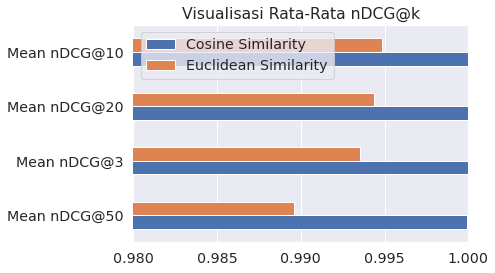

In [ ]:
fig, ax = plt.subplots()
df_evaluasi_models.sort_values(by='Euclidean Similarity').plot(kind='barh', ax=ax, zorder=3)
plt.xlim([0.98, 1.0])
plt.title("Visualisasi Rata-Rata nDCG@k")
plt.legend(loc='upper left')
ax.grid(zorder=0)

Dari visualisasi di atas, terlihat bahwa secara keseluruhan metode *Cosine Similarity* memiliki skor $\text{nDCG@}k$ yang lebih tinggi dibandingkan dengan metode *Euclidean Similarity*. Skor $\text{nDCG@}k$ terendah *Euclidean Similarity* adalah 0.98957381 yang artinya tingkat *error* terhadap *ground truth* adalah sebesar 0.01042619 atau sekitar 1.04%. Sedangkan pada *Cosine Similarity* skor terendahnya sebesar 0.99994934 yang artinya tingkat *error* terhadap *ground truth* sebesar 0.00005066 atau sekitar 0.005%.

### Komparasi Waktu Komputasi

Selain metrik $\text{nDCG@}k$ kita juga perlu mempertimbangkan lama waktu komputasi pada kedua metode yang digunakan. Berikut hasil komparasi lama waktu eksekusi tiap metode.

In [ ]:
df_exec_time_models = pd.DataFrame(index=['Time (Seconds)'],
    columns=['Jaccard Similarity (Ground Truth)', 'Cosine Similarity', 'Euclidean Similarity'])

df_exec_time_models['Jaccard Similarity (Ground Truth)'] = [jaccard_exec_time]
df_exec_time_models['Cosine Similarity'] = [cosine_exec_time]
df_exec_time_models['Euclidean Similarity'] = [euclidean_exec_time]

df_exec_time_models

,Jaccard Similarity (Ground Truth),Cosine Similarity,Euclidean Similarity
Time (Seconds),101.195608,0.758377,1.784877


Dari hasil tabel di atas, terdapat perbedaan yang signifikan antara lama waktu eksekusi metode *Jaccard Similarity* yang digunakan pada *ground trutuh* dengan dua metode lainnya (*Cosine Similarity* dan *Euclidean Similarity*). Dimana selisih waktunya lebih dari 1 menit. Kemudian untuk waktu eksekusi metode *Cosine Similarity* lebih cepat dibandingkan waktu eksekusi metode *Euclidean Similarity*.

## Kesimpulan

Berdasarkan hasil evaluasi model di atas, dapat kita simpulkan bahwa model terbaik untuk melakukan rekomendasi film berdasarkan genre adalah model dengan metode Cosine Similarity. Hal ini terbukti dengan nilai $\text{nDCG@}k$ pada metode *Cosine Similarity* terbukti lebih tinggi dari metode *Euclidean Similarity* baik itu pada top-3, top-10, top-20 maupun top-50 rekomendasi film. Artinya hasil rekomendasi oleh metode *Cosine Similarity* mempunyai tingkat relevansi yang lebih tinggi dari pada metode *Euclidean Similarity*. Selain itu, waktu komputasi model dengan metode *Cosine Similarity* (0.7584 detik) terbukti lebih cepat daripada metode *Euclidean Similarity* (1.7849 detik).

Kemudian perbandingan hasil rekomendasi antara metode *Cosine Similarity* dengan metode *Jaccard Similarity (ground truth)* menunjukkan tingkat kemiripan yang tinggi. Dengan nilai $\text{nDCG@}k$ pada top-3 (skor: 1), top-10 (skor: 1), top-20 (skor: 1) dan top-50 (skor: 0.99994934). Selain itu, untuk lama waktu komputasi metode *Cosine Similarity* lebih unggul dengan perolehan waktu (0.7584 detik) yang 100 detik lebih cepat dibandingkan waktu komputasi metode *Jaccard Similarity (ground truth)* (101.1956 detik). Sehingga metode *Cosine Similarity* dapat menjadi alternatif utama pengganti *Jaccard Similarity* yang sebelumnya dijadikan sebagai *ground truth*.

## Daftar Referensi

[1] A. Koufakou, J. Secretan, J. Reeder, K. Cardona and M. Georgiopoulos, "Fast parallel outlier detection for categorical datasets using MapReduce," 2008 IEEE International Joint Conference on Neural Networks (IEEE World Congress on Computational Intelligence), 2008, pp. 3298-3304, doi: 10.1109/IJCNN.2008.4634266. Tersedia: [tautan](https://www.eecs.ucf.edu/georgiopoulos/sites/default/files/247.pdf). Diakses pada Oktober 2022.  
[2] Verma, V., Aggarwal, R.K. A comparative analysis of similarity measures akin to the Jaccard index in collaborative recommendations: empirical and theoretical perspective. Soc. Netw. Anal. Min. 10, 43 (2020). https://doi.org/10.1007/s13278-020-00660-9. Tersedia: [Springer Link](https://link.springer.com/article/10.1007/s13278-020-00660-9).  
[3] Melville, Prem, and Vikas Sindhwani. "Recommender systems." Encyclopedia of machine learning 1 (2010): 829-838. Tersedia: [tautan](http://www.snet.tu-berlin.de/fileadmin/fg220/courses/SS11/snet-project/recommender-systems_asanov.pdf). Diakses pada November 2022.  
[4] Segaran, Toby. "Programming Collective Intelligence". O'Reilly Media, Inc. 2007. Tersedia: [O'Reilly Media](https://www.oreilly.com/library/view/programming-collective-intelligence/9780596529321/).  
[5] Jain, A. K.; Murty, M. N.; Flynn, P. J. (1999). Data clustering: a review. ACM Computing Surveys, 31(3), 264–323. doi:10.1145/331499.331504. Tersedia: [tautan](https://dl.acm.org/doi/pdf/10.1145/331499.331504). Diakses pada Oktober 2022.  
[6] Jarvelin, K., & Kekalainen, J. (2002). Cumulated gain-based evaluation of IR techniques. ACM Transactions on Information Systems (TOIS), 20(4), 422-446. Tersedia: [tautan](https://faculty.cc.gatech.edu/~zha/CS8803WST/dcg.pdf). Diakses pada November 2022.  
[7] McSherry, F., & Najork, M. (2008, March). Computing information retrieval performance measures efficiently in the presence of tied scores. In European conference on information retrieval (pp. 414-421). Springer, Berlin, Heidelberg. Tersedia: [tautan](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/ecir2008.pdf). Diakses pada November 2022.

## Data Author
* Moch Galang Rivaldo
* https://www.dicoding.com/users/reevald
* mochammadgalangrivaldo@gmail.com